# Annotator to create fine-tuning data for GPT models that extract relationships between concepts from the medical literature

In [1]:
import pandas as pd
import time
from datetime import datetime
import os
import openai
import subprocess
from io import StringIO
import re

Milestone training datasets:
- [GPT_extraction_datafile_for_causation.csv](GPT_extraction_datafile_for_causation.csv) Initial simple knowledge model focused only on `CAUSES` relationships. About 900 training examples were human-curated.
- [GPT_extraction_datafile_for_causation_with_conditions.csv](GPT_extraction_datafile_for_causation_with_conditions.csv) 2nd iteration knowledge model that included `STATE_OF`, `IS_A`, and some other relationship types. About 134 training examples were human-curated.
- [Afib_fine-tuning_dataset.csv](Afib_fine-tuning_dataset.csv) 3rd iteration knowledge model developed with [UseCase_AntiCoag_AF.ipynb](UseCase_AntiCoag_AF.ipynb)

Milestone models:
- fine-tune_model_name for GPT3 model trained on 800 training examples and validated against 100 training examples from [GPT_extraction_datafile_for_causation.csv](GPT_extraction_datafile_for_causation.csv): 'curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-15-22-47-59'

In [2]:
# Load the dataset that you're annotating
datafile = 'Afib_fine-tuning_dataset.csv'
df = pd.read_csv(datafile, encoding='utf-8', dtype={'pmid': str})

## To-Do:
- figure out how to store path parameters

<a id='GPT3_fine_tuner'></a>
## Helper functions
### For automatic fine-tuning

In [3]:
def finetune(row_number, datafile):
        
    # Create prefix for file names associated with this fine-tuning job
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    file_name_prefix = 'GPT_fine-tune_version' + timestamp
    
    # Create a folder structure to save files associated with this job
    file_path = 'Med_Lit_Extraction/Fine_Tuning/GPT3/'
    subprocess.run(["mkdir", '-p', file_path])
    
    # Create a log file
    log_file_name = file_path + 'log.txt'
    log_file = open(log_file_name, mode='a')
    
    def log_events(message):
        log_file.write('\n' + message)
        print(message)
        
        return "Logged"
    
    # Start the log file entry
    log_events('New fine-tune event started at ' + timestamp + ' on row ' + str(row_number) + ' of the dataset ' + datafile)
    
    # Load the dataset that you're annotating
    df = pd.read_csv(datafile, encoding='utf-8')
    
    annotated = df.iloc[:row_number+1].copy()
    
    # Replace NaN with '\n\n' strings in the relationships column
    annotated['relationships'] = annotated['relationships'].fillna('\n\n')
    
    # Add a separator at the end of each prompt to signal the end of the dividing point between the prompt and completion
    annotated['focused_sentences'] = annotated['focused_sentences'].astype(str) + '\n\n###\n\n'
    
    # Add a whitespace character at the beginning of each completion and a stop token like ### at the end of each completion
    annotated['relationships'] = ' ' + annotated['relationships'].astype(str) + '#####'
    
    # rename columns to match GPT3's prompt/completion format
    gpt3_out = annotated[['focused_sentences','relationships']].copy() # Keep only the columns needed for fine-tuning
    gpt3_out.rename(columns = {'focused_sentences':'prompt', 'relationships':'completion'}, inplace=True)
    gpt3_out.drop_duplicates(inplace = True)
    
    # Split the training and validation sets into different dataframes
    gpt3_out_training = gpt3_out[:-100]
    gpt3_out_validation = gpt3_out[-100:]
    
    # Save the fine-tuning training dataset to a JSONL file
    training_filename = file_name_prefix + 'training_dataset.jsonl'
    gpt3_out_training.to_json(path_or_buf = file_path + training_filename, orient='records', lines=True)
    log_events('Training file has ' + str(len(gpt3_out_training)) + ' rows and is named ' + training_filename)
    
    # Save the fine-tuning validation dataset to a JSONL file
    validation_filename = file_name_prefix + 'validation_dataset.jsonl'
    gpt3_out_validation.to_json(path_or_buf = file_path + validation_filename, orient='records', lines=True)
    log_events('Validation file has ' + str(len(gpt3_out_validation)) + ' rows and is named ' + validation_filename)
    
    # Connect to the openAI API
    openai.api_key = os.getenv("OPENAI_API_KEY")
    
    # Upload the fine-tuning JSONL files to openAI
    training_upload = openai.File.create(file=open(file_path + training_filename), purpose='fine-tune')
    log_events('Training file uploaded. The file ID for this training file is ' + training_upload.id)
    validation_upload = openai.File.create(file=open(file_path + validation_filename), purpose='fine-tune')
    log_events('Validation file uploaded. The file ID for this validation file is ' + validation_upload.id)
    
    # Submit the tuning job following instructions at https://beta.openai.com/docs/api-reference/fine-tunes/create?lang=python 
    batch_size = max(4, round(len(gpt3_out_training)/25)) # for larger training files, increase the batch size
    fine_tune_job = openai.FineTune.create(training_file=training_upload.id, validation_file=validation_upload.id, batch_size = batch_size, use_packing=False)
    log_events('Fine-tuning job submitted. The ID for this job is ' + fine_tune_job.id + '\nFine-tuning in progress...')
    
    # Check on the fine-tuning progress. Wait for fine-tuning to finish before proceeding. Timeout after 20 minutes.
    events = openai.FineTune.list_events(id=fine_tune_job.id)
    seconds_timer = 0

    if events.data[-1].message == 'Fine-tune succeeded':
        for event in events.data:
            if event.message[:22] == 'Uploaded result file: ':
                result_file_id = event.message[22:]
            if event.message[:16] == 'Uploaded model: ':
                model_name = event.message[16:]
    else:
        while events.data[-1].message != 'Fine-tune succeeded':
            delay = 20
            seconds_timer += delay
            if seconds_timer > 1200:
                log_events("Fine-tuning took longer than 20 minutes or failed. Latest event log:\n" + events.data)
                break
            time.sleep(delay)
            
            events = openai.FineTune.list_events(id=fine_tune_job.id)
            
            for event in events.data:
                if event.message[:22] == 'Uploaded result file: ':
                    result_file_id = event.message[22:]
                if event.message[:16] == 'Uploaded model: ':
                    model_name = event.message[16:]
    
    log_events('Fine-tune succeeded after ' + str(seconds_timer) + ' seconds.\nFine-tuned model name: ' + model_name + '\nResult file ID: ' + result_file_id)
    
    # Get results file and save it to a CSV
    results = subprocess.run(["openai", 'api', 'fine_tunes.results', '-i',  fine_tune_job.id], stdout=subprocess.PIPE, text=True)
    results_io = StringIO(results.stdout)
    results_df = pd.read_csv(results_io)
    results_filename = file_name_prefix + 'results.csv'
    results_df.to_csv(file_path + results_filename, index=False)
    log_events('Result file saved as: ' + results_filename)
    
    # Display model accuracy
    validation_df = results_df.dropna(subset = ['validation_loss', 'validation_sequence_accuracy','validation_token_accuracy'], how='any').copy()
    validation_fig = validation_df.iloc[:,6:].plot(xlabel='Training step', title='Model Accuracy', figsize=(10,6))
    print(validation_fig)
    
    # Return a cache of all the local variables for reference
    summary = {
        'Fine-tune_start_time':timestamp,
        'input_row_number':row_number,
        'input_datafile':datafile,
        'training_filename':training_filename,
        'validation_filename':validation_filename,
        'training_set_ID':training_upload.id,
        'validation_set_ID':validation_upload.id,
        'fine-tune_job_ID':fine_tune_job.id,
        'fine-tune_model_name':model_name,
        'result_file_ID':result_file_id,
        'training_results_filename':results_filename,
    }
    
    log_events('\n'+ str(summary) + '\n\n')
    log_file.close()
    
    return summary

### For sending a prompt to GPT3
Be sure to run the cells in this section before you start up the annotator

In [4]:
def completion_for(prompt, model):
    response = openai.Completion.create(
        model=model,
        prompt=prompt,
        max_tokens = 100,
        temperature = 0.5,
        stop=["\n#####"])
    completion = response.choices[0].text
    
    parameters = {
        'max_tokens': 100,
        'temperature': 0.5,
        'stop':"\n#####"
    }
    
    return completion, parameters

### For identifying UMLS terms in text

In [5]:
str_to_AUI = pd.read_csv('MRCONSO_for_import.csv', usecols=['AUI', 'STR'], encoding='utf-8')
str_to_AUI.sort_values(by='STR', inplace=True)
str_to_AUI.head()

,AUI,STR
4845469,A8312841,""""" w/o Surgery Capability"
8419781,A32033560,!Orthotrichum mandonii
8232382,A31943997,"!Orthotrichum mandonii Schimp. ex Hampe, 1865"
10305591,A18194383,# CA pos tissue chips CAP prot
10322909,A22765129,# D AG was worn on PhenX


In [14]:
str_to_AUI['STR'] = str_to_AUI['STR'].str.lower()

In [15]:
# Define a function that conducts a fast binary search on a sorted column of a dataframe, returning only full match results.

def binary_search(dataframe, column, target):
    target = target.lower()
    range_start = 0
    range_end = len(dataframe)-1
    while range_start < range_end:
        range_middle = (range_end + range_start) // 2
        value = dataframe.iloc[range_middle][column]
        if value == target:
            return dataframe.iloc[range_middle]
        elif value < target:
            # Discard the first half of the range
            range_start = range_middle + 1
        else:
            # Discard the second half of the range
            range_end = range_middle - 1
    # At this point range_start = range_end
    value = dataframe.iloc[range_start][column]
#     return value
    if value == target:
        return dataframe.iloc[range_start]
    else:
        return 0

In [16]:
# Define a function which takes a string and returns a list of CUIs or the strings associated with CUIs

def text_to_AUIs(text):
    
    # Remove any non-alphanumeric characters, set the encodning to unicode, and split the text into a list of words
    text = re.sub('[\W_]+', ' ', text, flags=re.UNICODE)
    text = text.split(' ')

    # Iterate through the list of words to find the largest sets of consecutive words that match CUI-associated strings, and append these to a term list
    used = set([])
    term_list = []
    for i in reversed(range(1,6)):
        index = 0
        while index < len(text):
            if not index in used:
                term = ' '.join(text[index:(index+i)])
                frame = binary_search(dataframe = str_to_AUI, column = 'STR', target = term)
                if type(frame) == int:
                    index += 1
                else:
                    used.update(range(index, index+i))
                    term_list.append([index, term, frame['AUI']])
                    index += i
            else:
                index += 1
    
    # Append any non-matched words to the term list
    index = 0
    for word in text:
        if not index in used:
            term_list.append([index, word])
        index += 1

    # Sort the term list according to the order of the terms in the original text
    term_list = sorted(term_list, key=lambda x: x[0])
    
    outlist = []
    for word in term_list:
        if len(word) == 3:
#             outlist.append('('+word[1]+' '+word[2]+')')
            outlist.append('('+word[1]+')')
        else:
            outlist.append(word[1])
            
    return ' '.join(outlist)

<a id='annotator_tool'></a>
## Annotator

In [8]:
# Initialize row_number wherever you left off
row_number = 0

In [31]:
# For reviewing previously annotated sentences
row_number += 1
print("Row",row_number)

prompt = df.iloc[row_number,].focused_sentences
current_relationships = df.iloc[row_number,].relationships

# Display the model's prediction and the prompt
print("Current relationships:\n",current_relationships, '\n')
print("Prompt:\n",prompt)

# Display the prompt text with UMLS terms highlighted
print('\n',text_to_AUIs(prompt))

Row 0
Current relationships:
 nan 

Prompt:
  Patient and Methods: An 85-year-old man was transferred to a regional hospital due to sudden onset of dysarthria and left hemiparesis. 

  (Patient) (and) (Methods) (An) (85) (year) (old) (man) was (transferred) to (a) (regional) (hospital) (due to) (sudden onset of) (dysarthria) (and) (left hemiparesis) 


In [54]:
# For using GPT3 predictions to assist with annotating new sentences
# row_number += 1
row_number = 0
print("Row",row_number)

# Get a prediction from the model
model = 'curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-15-22-47-59'
prompt = df.iloc[row_number,].text
completion, parameters = completion_for(prompt, model)

# Write the model's prediction back to the dataframe
df.at[row_number,model] = completion

# Display the model's prediction and the prompt
print("GPT model's results: ",completion, '\n')
print("Prompt:\n",prompt)

# Display the prompt text with UMLS terms highlighted
# print('\n',text_to_AUIs(prompt))

Row 0
GPT model's results:   

###

 
 

Prompt:
 PATTERNS OF INFARCTION ON MRI IN PATIENTS WITH ACUTE ISCHEMIC STROKE AND CARDIO-EMBOLISM: A SYSTEMATIC REVIEW AND META-ANALYSIS. Background: Cardioembolic strokes are common however atrial fibrillation, the most common cause, is often asymptomatic and difficult to detect. There is evidence that infarct topography and volume on magnetic resonance imaging may be associated with specific stroke etiologies. Aim: A systematic review and meta-analysis were undertaken to summarize the available evidence on the association between stroke etiology, infarct topography, and volume. Methods: A systematic review was conducted using Medline (OVID), Embase (OVID), and PubMed databases. Hand searches of the gray literature and of reference lists in relevant articles were also performed. A quality assessment was undertaken, based on the STROBE checklist. For each study, the number of patients with and without a CE source of stroke and infarct topography

In [42]:
# Add a list of the relationships described in the extracts from the article. Separate fields for each relationship
# with | and separate relationships with new lines, as follows: subject | verb | object
df.at[row_number,'relationships'] = [
    'atrial fibrillation | CAUSES | Cardioembolic strokes |',
]

# df.to_csv(datafile, index=False)
# print('Saved ',datafile)

# print("Row",row_number)
print('\n', df.iloc[row_number].relationships)


 ['cerebral small vessel disease | synonym | SVD', 'cerebral small vessel disease | causes | stroke |', 'cerebral small vessel disease | causes | mild cognitive impairment |', 'cerebral small vessel disease | causes | dementia |', 'cerebral small vessel disease | causes | physical impairments |']


In [10]:
df

,pmid,publication_types,focused_sentences,text,Level_of_Evidence,relationships
0,33363511,['Systematic Review'],Background: Cardioembolic strokes are common ...,PATTERNS OF INFARCTION ON MRI IN PATIENTS WITH...,4,
1,34738758,['Practice Guideline'],Hemostasis work-up is frequently requested in...,[HOW I EXPLORE… HÉMOSTATIC ABNORMALITIES IN PE...,4,NaN
2,34444685,"['Journal Article', 'Systematic Review']","Conversely, breakfast skipping resulted in sig...",THE WINDOW MATTERS: A SYSTEMATIC REVIEW OF TIM...,4,NaN
3,34226040,"['Journal Article', 'Meta-Analysis', 'Systemat...",We performed a meta-analysis to pool results ...,META-ANALYSIS OF USEFULNESS OF ANTIPLATELET TH...,4,NaN
4,33746889,['Systematic Review'],Identifying the underlying cause of a metabol...,INHERITED METABOLIC CAUSES OF STROKE IN CHILDR...,4,NaN
...,...,...,...,...,...,...
3843,34779281,['Journal Article'],"Indeed, aortic stiffness and the loss of the ...",IS IT GOOD TO HAVE A STIFF AORTA WITH AGING? C...,10,NaN
3844,34100419,['Journal Article'],Taking advantage of the fast-growing knowledg...,GENES FOR RNA-BINDING PROTEINS INVOLVED IN NEU...,10,NaN
3845,33890206,"['Journal Article', 'Research Support, N.I.H.,...",We report that intervention starting at 7-8 m...,BETA-GUANIDINOPROPIONIC ACID HAS AGE-SPECIFIC ...,10,NaN
3846,33993312,['Journal Article'],The significance of the association of PFO wi...,STROKE IN YOUNG MILITARY MEN WITH HETEROZYGOUS...,10,NaN


Upload progress: 100%|██████████| 25.3k/25.3k [00:00<00:00, 4.61Mit/s]

Congratulations! You just finished another 100 training examples.
    Time to take a well-earned break while GPT learns from what you've just done. This may take a few minutes.
Training file has 101 rows and is named GPT3_fine-tuning_dataset_v12-10-2021_16-54.jsonl
Validation file has 100 rows and is named GPT3_fine-tuning_dataset_validation_v12-10-2021_16-54.jsonl



Upload progress: 100%|██████████| 25.7k/25.7k [00:00<00:00, 5.42Mit/s]

Training file uploaded. The file ID for this training file is file-91VrcV0r0NqKM5lkdS6QfUDv


Validation file uploaded. The file ID for this validation file is file-pQquWRfprJLGQ0ebt2XI6IbG
Fine-tuning job submitted. The ID for this job is ft-VvwUtGB6J3ZM2CmY7jy01OCM
Fine-tuning in progress...
Fine-tune succeeded after 180 seconds.
Fine-tuned model name: curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-12-23-57-28
Result file ID: file-ueB9Nl6NXjDdYgXavXjqsARa
Result file saved as: GPT_causal_extraction_fine-tuning_results_v12-10-2021_16-54.csv
AxesSubplot(0.125,0.125;0.775x0.755)


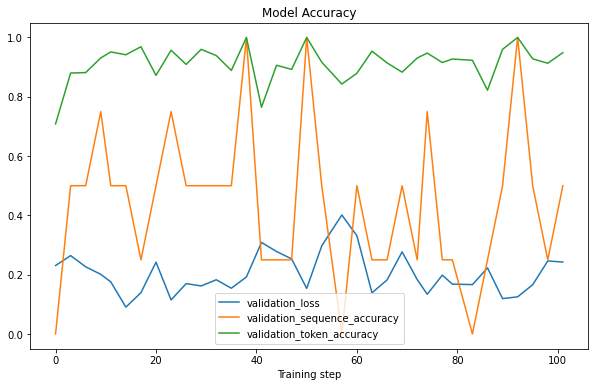

In [263]:
training_prompts_100 = finetune(row_number=200, datafile=datafile)

Upload progress:   0%|          | 0.00/50.1k [00:00<?, ?it/s]

Congratulations! You just finished another 100 training examples.
    Time to take a well-earned break while GPT learns from what you've just done. This may take a few minutes.
Training file has 199 rows and is named GPT3_fine-tuning_dataset_v13-10-2021_11-01.jsonl
Validation file has 100 rows and is named GPT3_fine-tuning_dataset_validation_v13-10-2021_11-01.jsonl


Upload progress: 100%|██████████| 50.1k/50.1k [00:00<00:00, 232kit/s] 
Upload progress: 100%|██████████| 26.2k/26.2k [00:00<00:00, 8.26Mit/s]

Training file uploaded. The file ID for this training file is file-g3DLj7YgewoejCa5CqX0kyA8


Validation file uploaded. The file ID for this validation file is file-yXwS4wBtHtoo2cylQo3I8Gzy
Fine-tuning job submitted. The ID for this job is ft-Q7cX3nzshtlvyZQ8o8qTBPgZ
Fine-tuning in progress...
Fine-tune succeeded after 280 seconds.
Fine-tuned model name: curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-13-18-05-44
Result file ID: file-pE8i3g6cZIvlc885Cg7WyiZK
Result file saved as: GPT_causal_extraction_fine-tuning_results_v13-10-2021_11-01.csv
AxesSubplot(0.125,0.125;0.775x0.755)


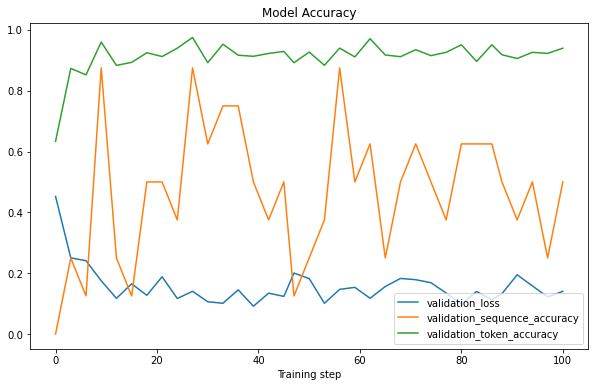

In [267]:
training_prompts_200 = finetune(row_number=300, datafile=datafile)

Upload progress: 100%|██████████| 103k/103k [00:00<00:00, 981kit/s]  

Congratulations! You just finished another 100 training examples.
    Time to take a well-earned break while GPT learns from what you've just done. This may take a few minutes.
Training file has 399 rows and is named GPT3_fine-tuning_dataset_v13-10-2021_11-06.jsonl
Validation file has 100 rows and is named GPT3_fine-tuning_dataset_validation_v13-10-2021_11-06.jsonl



Upload progress: 100%|██████████| 26.1k/26.1k [00:00<00:00, 7.92Mit/s]

Training file uploaded. The file ID for this training file is file-Uq9ts4EycwvPYqN03kZU8KYB


Validation file uploaded. The file ID for this validation file is file-YjqsIpy1niZ0If8aAF37bPsh
Fine-tuning job submitted. The ID for this job is ft-6y2zKlT5ot4koj8ipc7kY0w8
Fine-tuning in progress...
Fine-tune succeeded after 400 seconds.
Fine-tuned model name: curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-13-18-13-06
Result file ID: file-US38nBJidRIxIowAiGCifZMF
Result file saved as: GPT_causal_extraction_fine-tuning_results_v13-10-2021_11-06.csv
AxesSubplot(0.125,0.125;0.775x0.755)


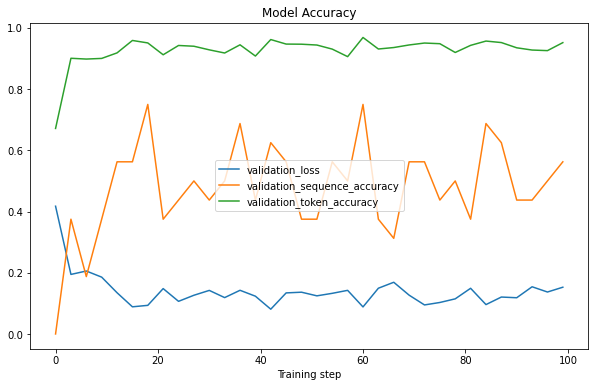

In [268]:
training_prompts_400 = finetune(row_number=500, datafile=datafile)

Upload progress:   0%|          | 0.00/195k [00:00<?, ?it/s]

New fine-tune event started at 2021-10-15-15-36-20 on row 900 of the dataset GPT_extraction_datafile_for_causation.csv
Training file has 798 rows and is named GPT_fine-tune_version2021-10-15-15-36-20training_dataset.jsonl
Validation file has 100 rows and is named GPT_fine-tune_version2021-10-15-15-36-20validation_dataset.jsonl


Upload progress: 100%|██████████| 195k/195k [00:00<00:00, 675kit/s]  
Upload progress: 100%|██████████| 25.7k/25.7k [00:00<00:00, 9.25Mit/s]

Training file uploaded. The file ID for this training file is file-bfWUudBZwioK0gNzmroKSvAD


Validation file uploaded. The file ID for this validation file is file-oxsDBxxr16tOvWlT9JeU58z1
Fine-tuning job submitted. The ID for this job is ft-hZugMxKnbQnyU3u8v9N4fdm8
Fine-tuning in progress...
Fine-tune succeeded after 700 seconds.
Fine-tuned model name: curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-15-22-47-59
Result file ID: file-iGu2U0QRNKzVqQs9jvbphpkp
Result file saved as: GPT_fine-tune_version2021-10-15-15-36-20results.csv
AxesSubplot(0.125,0.125;0.775x0.755)

{'Fine-tune_start_time': '2021-10-15-15-36-20', 'input_row_number': 900, 'input_datafile': 'GPT_extraction_datafile_for_causation.csv', 'training_filename': 'GPT_fine-tune_version2021-10-15-15-36-20training_dataset.jsonl', 'validation_filename': 'GPT_fine-tune_version2021-10-15-15-36-20validation_dataset.jsonl', 'training_set_ID': 'file-bfWUudBZwioK0gNzmroKSvAD', 'validation_set_ID': 'file-oxsDBxxr16tOvWlT9JeU58z1', 'fine-tune_job_ID': 'ft-hZugMxKnbQnyU3u8v9N4fdm8', 'fine-tune_model_name': 'curie:ft-user-92vwagyayt

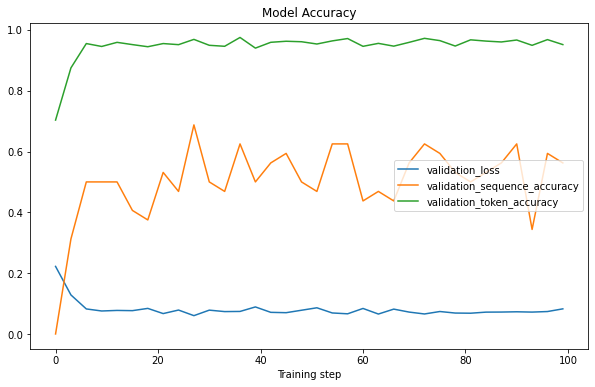

In [942]:
training_prompts_800 = finetune(row_number=900, datafile=datafile)